In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


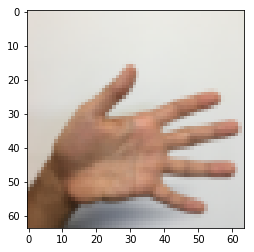

In [17]:
index = 0;
plt.imshow(X_train_orig[index])
print('y = ' + str(np.squeeze(Y_train_orig[:, index])))

In [18]:
# flattening the images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# normalizing
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255

# converting labels to one-hot encoding
Y_train = convert_to_one_hot(Y_train_orig, len(classes))
Y_test = convert_to_one_hot(Y_test_orig, len(classes))

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [19]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])

    return X, Y

In [21]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(6, ?), dtype=float32)


In [22]:
def initialize_parameters():
    tf.set_random_seed(1)

    W1 = tf.get_variable('W1', [25, 12288], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [25, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [6, 1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [23]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [24]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [25]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                  
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016411
Cost after epoch 200: 0.733188
Cost after epoch 300: 0.572921
Cost after epoch 400: 0.468836
Cost after epoch 500: 0.381291
Cost after epoch 600: 0.313962
Cost after epoch 700: 0.254535
Cost after epoch 800: 0.203957
Cost after epoch 900: 0.166740
Cost after epoch 1000: 0.142372
Cost after epoch 1100: 0.107723
Cost after epoch 1200: 0.085986
Cost after epoch 1300: 0.060894
Cost after epoch 1400: 0.051012


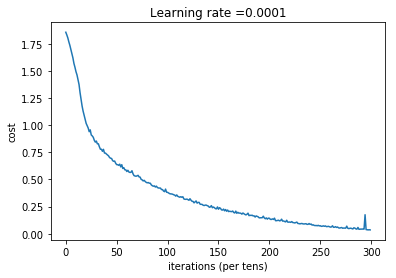

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [26]:
parameters = model(X_train, Y_train, X_test, Y_test)

/home/kartik/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/kartik/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Your algorithm predicts: y = 0


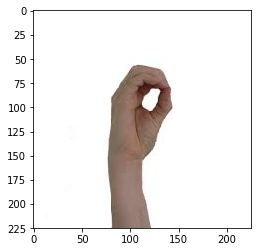

In [27]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "zero.jpeg"

fname = "./" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))